# <center> Прогнозирование ВВП Ганы по временному ряду

In [1]:
# Подгрузим инструментарий
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings
filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим данные.

In [2]:
ghana_gdp = pd.read_csv('data/ghana_gdp.zip', parse_dates=["year"], index_col=["year"])
ghana_gdp.rename(columns = {'GDP (current US$)':'gdp'}, inplace=True) 
print('Data shape:', ghana_gdp.shape)
ghana_gdp.head()

Data shape: (62, 1)


,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [3]:
train_df = ghana_gdp.iloc[:-3]
test_df = ghana_gdp.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

Отрисуем динамику ВВП и ее представление через скользящее среднее с разными окнами.

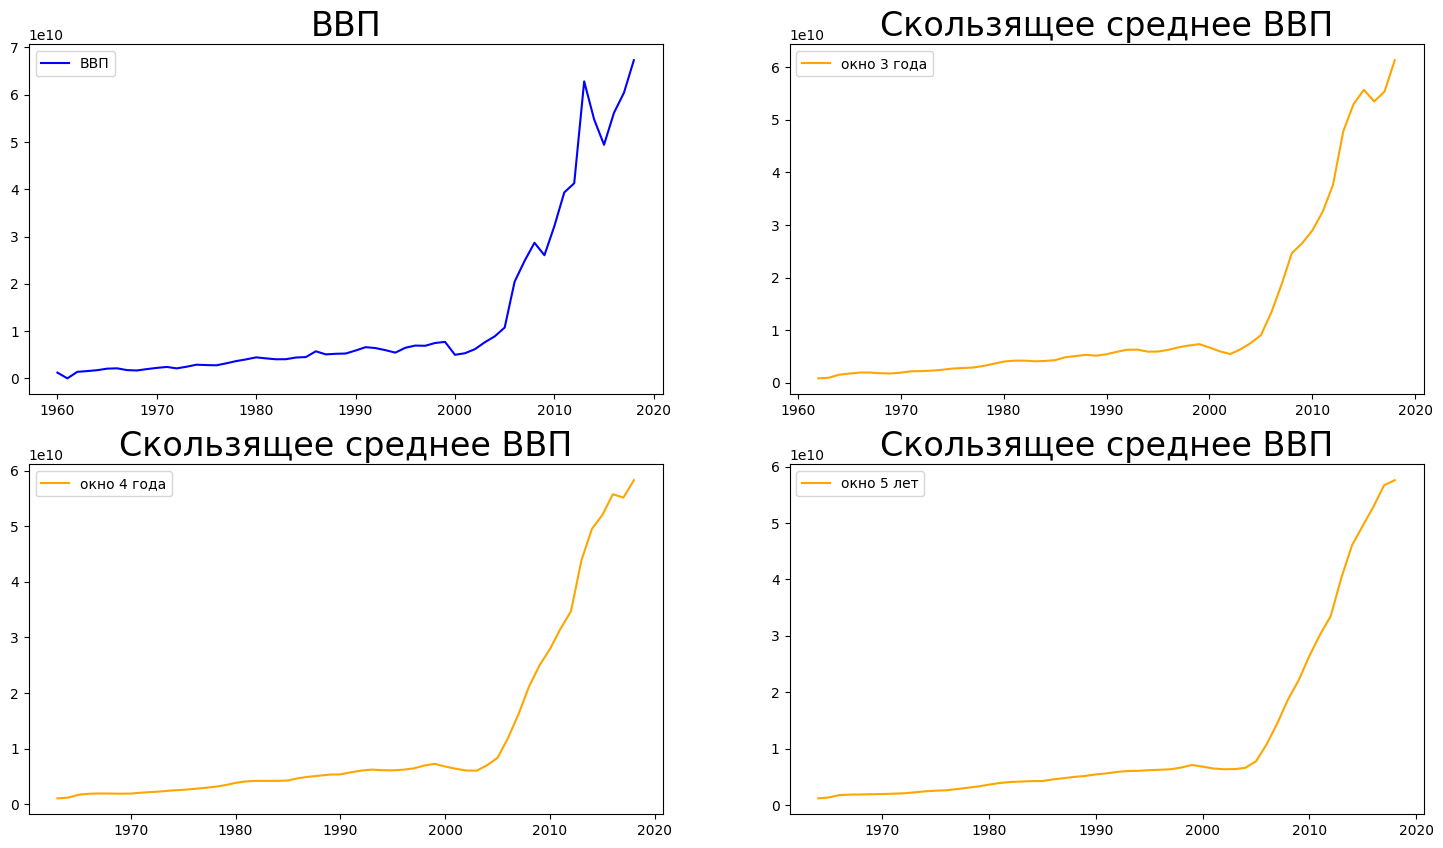

In [4]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df.gdp, color="blue", label="ВВП")
ax[0, 0].set_title("ВВП", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=3).mean(),
    color="orange",
    label="окно 3 года")
ax[0, 1].set_title("Скользящее среднее ВВП", size=24)
ax[0, 1].legend()

ax[1, 0].plot(
    train_df.rolling(window=4).mean(), 
    color="orange", label="окно 4 года")
ax[1, 0].set_title("Скользящее среднее ВВП", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="окно 5 лет")
ax[1, 1].set_title("Скользящее среднее ВВП", size=24)
ax[1, 1].legend()

plt.show()

Сезонность на глаз не угадывается, но тренд определенно имеется.

С помощью теста Дики-Фуллера оценим стационарность временного ряда и примем решение о выборе модели ARMA/ARIMA.

In [5]:
# Напишем функцию для проведения теста
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('ряд нестационарен')
    else:
        print ('ряд стационарен')

# Протестируем данные на трейне
stat_test(train_df)

adf:  0.6529066974885367
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть: динамика ВВП Ганы не является стационарным.

In [6]:
# Напишем функцию для отрисовки графиков автокорреляции
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=25)
    sgt.plot_pacf(series, ax=axes[1], lags=25, method="ywm")
    plt.show()

### Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

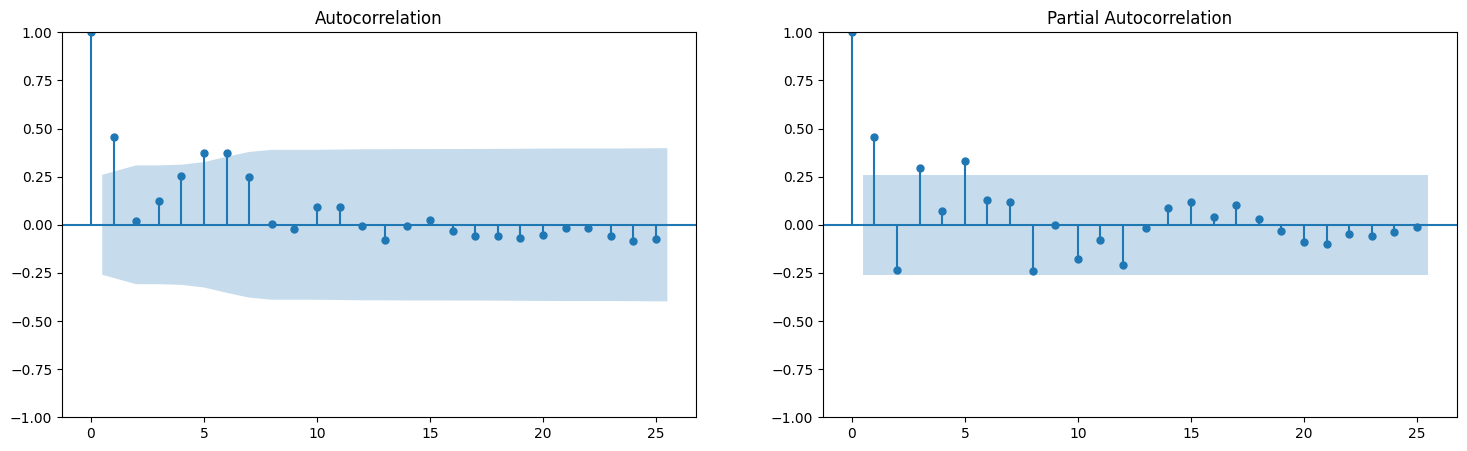

adf:  -3.5836708658260292
p-value:  0.006080989753876957
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [7]:
plot_acf_pacf(train_df["gdp"].diff(2).dropna())
stat_test(train_df["gdp"].diff(2).dropna())

### ARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 2 
- q = 1 

In [8]:
arima_model = ARIMA(train_df["gdp"], order=(1, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Sun, 07 Jan 2024   AIC                           2684.416
Time:                        21:06:58   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.95e+56. Standard errors may be unstable.
"""

Попробуем подобрать оптимальные параметры с помощью автоперебора.

In [9]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=5,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.02 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.05 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.800, Time=0.04 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2688.234, Time=0.04 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.409, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.06 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Sun, 07 Jan 2024   AIC                           2680.765
Time:                        21:06:58   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+55. Standard errors may be unstable.
"""

Построим модель с наилучшими параметрами и выполним предсказание для отложенной тестовой выборки.

In [10]:
pred_df = pd.DataFrame(index=ghana_gdp.index)

pred_df["model_preds"] = arima_model_fit.predict(
start=test_df.index[0], end=test_df.index[-1]   
)

pred_df["gdp"] = ghana_gdp["gdp"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

Взглянем на предсказания.

In [11]:
pred_df["model_preds"][-3:]

year
2019-01-01    7.021089e+10
2020-01-01    7.382914e+10
2021-01-01    7.732197e+10
Name: model_preds, dtype: float64

Построим графики истинного и предсказанного поведения временного ряда.

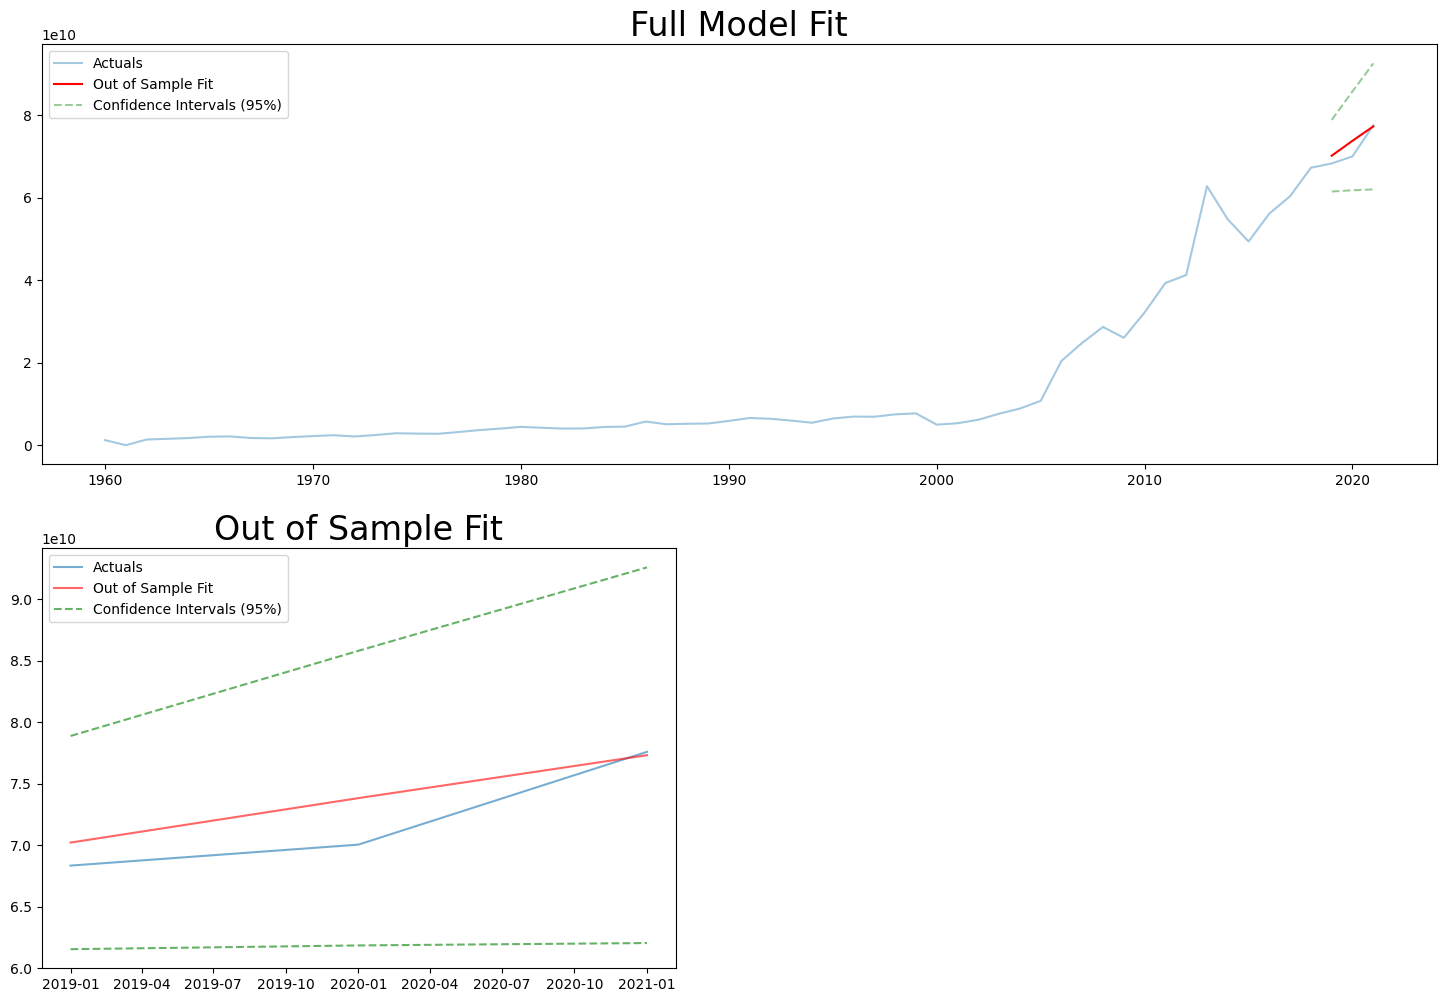

In [12]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Предсказание нашей модели оказалось чуть более оптимистичным на протяжении большей части интервала, но в самом конце оно все же сошлось с реальным значением.

### Интерполяция и сэмплирование

У нас имеется пропуск в данных и он представлен нулем, и чтобы его заполнить методом интерполяции нам потребуется поместить в соответствующую ячейку nan-значение.

In [13]:
ghana_gdp['gdp'] = ghana_gdp['gdp'].apply(lambda x: np.nan if x==0 else x)
ghana_gdp.isna().sum()

gdp    1
dtype: int64

Произведем интерполяцию.

In [14]:
ghana_gdp_interpolated = ghana_gdp.copy()
ghana_gdp_interpolated['gdp'] = ghana_gdp_interpolated['gdp'].interpolate(method='linear')
ghana_gdp_interpolated.head(3)

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


А было:

In [32]:
ghana_gdp.head(3)

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,NaN
1962-01-01,1.382353e+09


Разделим данные на трейн и тест выборку.

In [16]:
train_df_intrpltd = ghana_gdp_interpolated.iloc[:-3]
test_df_intrpltd = ghana_gdp_interpolated.iloc[-3:]
train_df_intrpltd.shape, test_df_intrpltd.shape

((59, 1), (3, 1))

Протестируем трейн на стационарность.

In [17]:
stat_test(train_df_intrpltd)

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Потребуется подобрать порядок дифференцирования.

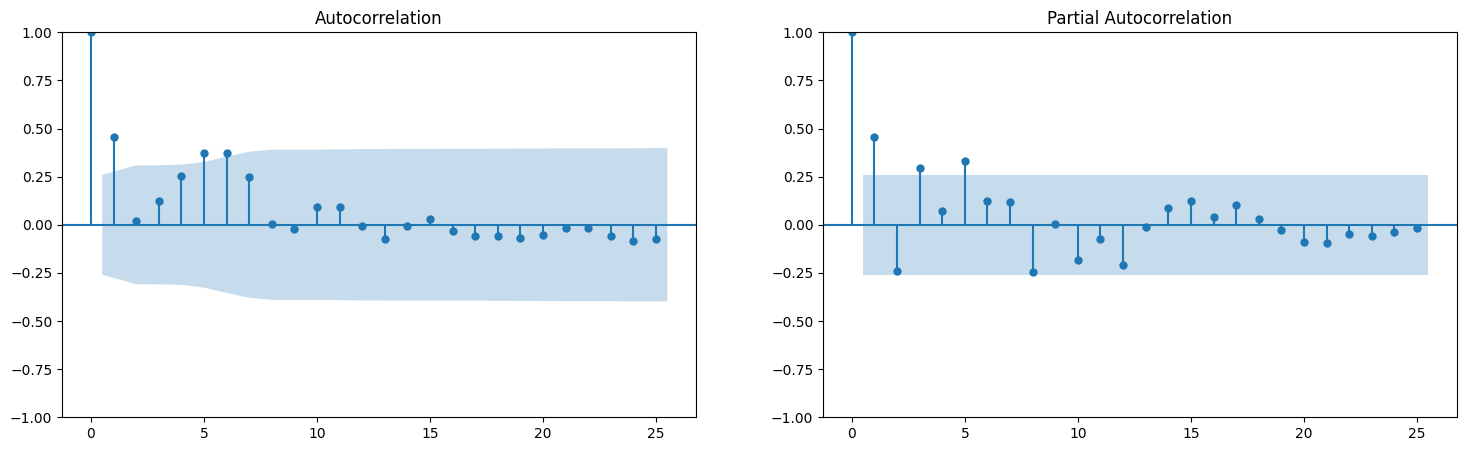

adf:  -3.99980344094915
p-value:  0.0014115408436661263
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [18]:
plot_acf_pacf(train_df_intrpltd["gdp"].diff(2).dropna())
stat_test(train_df_intrpltd["gdp"].diff(2).dropna())

Осуществим автоперебор.

In [19]:
smodel = pm.auto_arima(
    train_df_intrpltd,
    start_p=1,
    d=2,
    start_q=1,
    max_p=5,
    max_q=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.03 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.02 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.05 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.617, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2687.812, Time=0.04 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.040, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.08 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Sun, 07 Jan 2024   AIC                           2680.513
Time:                        21:06:59   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+55. Standard errors may be unstable.
"""

AIC на исходных данных (с пропуском) был чуть выше: 2680.765. Значит избавление от пропущенных значений с помощью интерполяции может улучшить итоговую модель.

### Модели прогнозирования гетероскедастичности. Валидация временных рядов

#### Волатильность 

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [20]:
ghana_gdp_interpolated["gdp_vol"] = ghana_gdp_interpolated.gdp.pct_change(1).mul(100).abs()
ghana_gdp_interpolated["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

Посмотрим на рассчитанную волатильность.

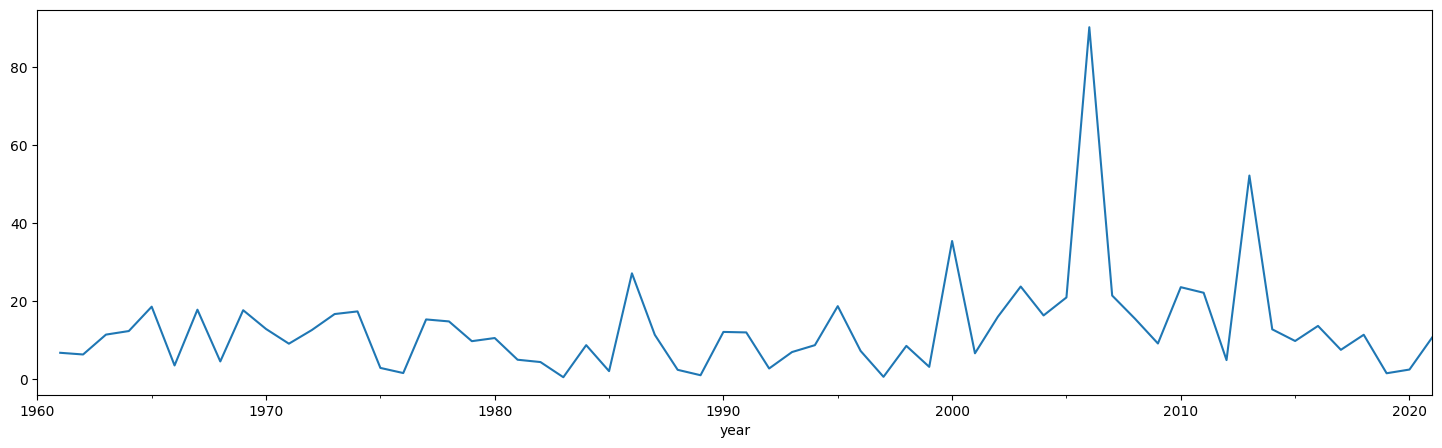

In [21]:
ghana_gdp_interpolated["gdp_vol"].plot();

Как можно видеть, дисперсия не однородна.

Разделим наш более полный теперь (после интерполяции) набор данных на трейн и тест.

In [36]:
train_df_full = ghana_gdp_interpolated.iloc[:-3]
test_df_full = ghana_gdp_interpolated.iloc[-3:]
train_df_full.shape, test_df_full.shape

((59, 2), (3, 2))

Отрисуем автокорреляцию и подберем дифф-порядок.

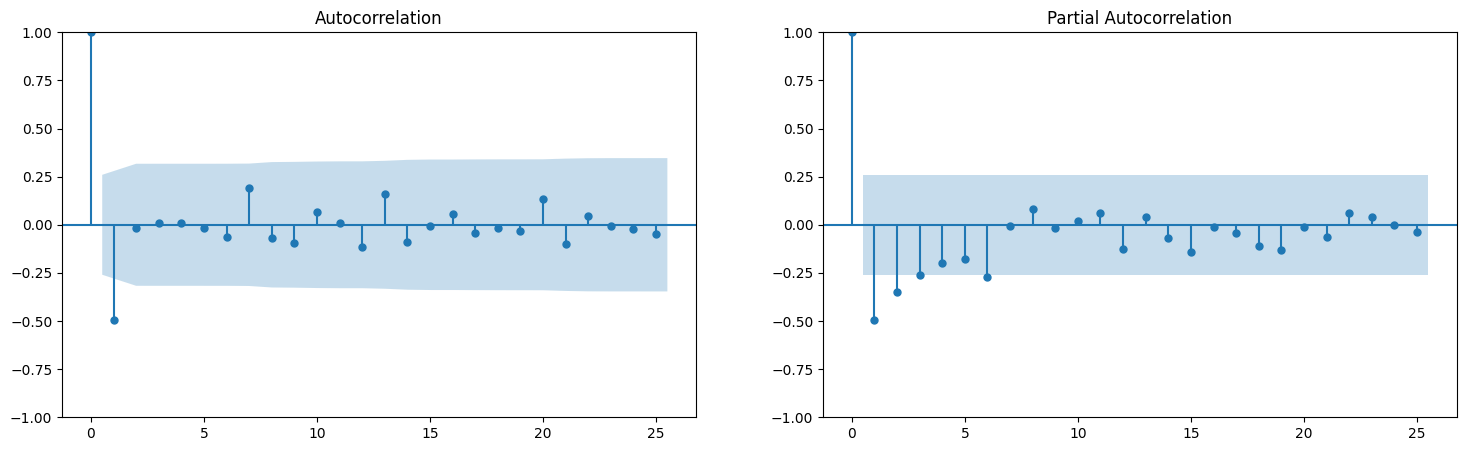

adf:  -5.507821854067958
p-value:  2.0032914920585e-06
Critical values:  {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
ряд стационарен


In [37]:
plot_acf_pacf(train_df_full.gdp_vol[1:].diff(1).dropna())
stat_test(train_df_full.gdp_vol[1:].diff(1).dropna())

Отдадим трейн автоариме.

In [38]:
smodel = pm.auto_arima(
    train_df_full.gdp_vol[1:],
    start_p=1,
    d=1,
    start_q=2,
    max_p=10,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=497.261, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=483.462, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=495.262, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=478.380, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=476.543, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=476.387, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=476.442, Time=0.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=476.105, Time=0.06 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=475.874, Time=0.10 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=473.875, Time=0.05 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=475.874, Time=0.05 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(6, 1, 0)   Log Likelihood                -228.958
Date:                Sun, 07 Jan 2024   AIC                            471.917
Time:                        21:17:13   BIC                            486.218
Sample:                    01-01-1961   HQIC                           477.475
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8907      0.201     -4.442      0.000      -1.284      -0.498
ar.L2         -0.7897      0.288     -2.741      0.006      -1.355      -0.225
ar.L3         -0.6703      0.283     -2.369      0.018      -1.225      -0.116
ar.L4         -0.5422      0.257     -2.108      0.035      -1.046      -0.038
ar.L5         -0.4245      0.170     -2.500      0.012      -0.757      -0.092
ar.L6         -0.2887      0.145     -1.994      0.046      -0.573      -0.005
sigma2       175.5447     18.657      9.409      0.000     138.978     212.111
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               649.76
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              13.06   Skew:                             3.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARCH

Инициализируем и обучим arch-модель.

In [39]:
model = arch_model(ghana_gdp_interpolated["gdp_vol"].dropna(), p=6, q=0)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df_full.index[0], update_freq=5)

Iteration:      5,   Func. Count:     46,   Neg. LLF: 219.51698683664048
Iteration:     10,   Func. Count:     91,   Neg. LLF: 218.41723443721753
Iteration:     15,   Func. Count:    141,   Neg. LLF: 238.3598256230869
Iteration:     20,   Func. Count:    188,   Neg. LLF: 217.6524042022527
Optimization terminated successfully    (Exit mode 0)
            Current function value: 217.65240355526723
            Iterations: 21
            Function evaluations: 197
            Gradient evaluations: 21


Выведем отчет по нашей модели.

In [26]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -217.652
Distribution:                  Normal   AIC:                           451.305
Method:            Maximum Likelihood   BIC:                           467.788
                                        No. Observations:                   58
Date:                Sun, Jan 07 2024   Df Residuals:                       57
Time:                        21:07:01   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.2582      1.206      9.335  1.012e-20 [  8.894, 13.622]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         52.4125     17.841      2.938  3.305e-03      [ 17.446, 87.379]
alpha[1]   1.0154e-03  6.761e-03      0.150      0.881 [-1.224e-02,1.427e-02]
alpha[2]       0.0000  1.649e-02      0.000      1.000 [-3.231e-02,3.231e-02]
alpha[3]       0.0000  3.779e-02      0.000      1.000 [-7.407e-02,7.407e-02]
alpha[4]   3.9460e-03  5.264e-03      0.750      0.453 [-6.371e-03,1.426e-02]
alpha[5]       0.0000  2.482e-02      0.000      1.000 [-4.865e-02,4.865e-02]
alpha[6]       0.9950      0.536      1.855  6.355e-02   [-5.612e-02,  2.046]
=============================================================================

Covariance estimator: robust
"""

### Предсказание

Осуществим предсказание.

In [27]:
predictions_df = test_df_full.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df_full.index]

Нарисуем предсказание совместно с истинной динамикой ВВП.

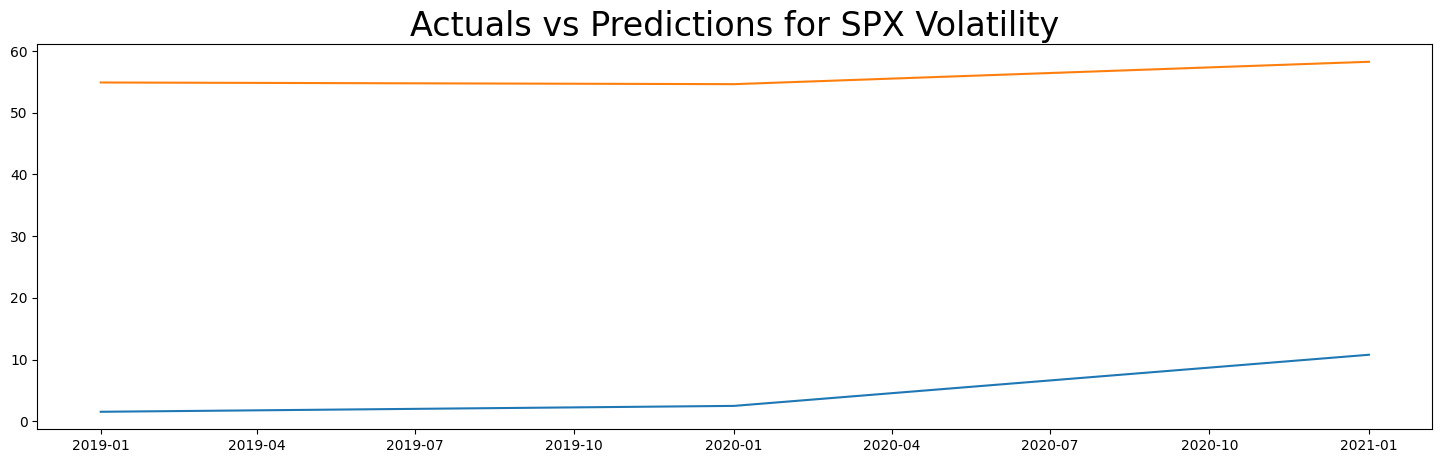

In [28]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [42]:
print('ARCH-models MSE: ', end='')
print(round(mean_squared_error(predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]), 4))

ARCH-models MSE: 2605.3542


Для измеряющегося в сотнях миллионах ВВП это, наверное, довольно небольшая ошибка.

Посмотрим как с нашей задачей справится линейная регрессия.

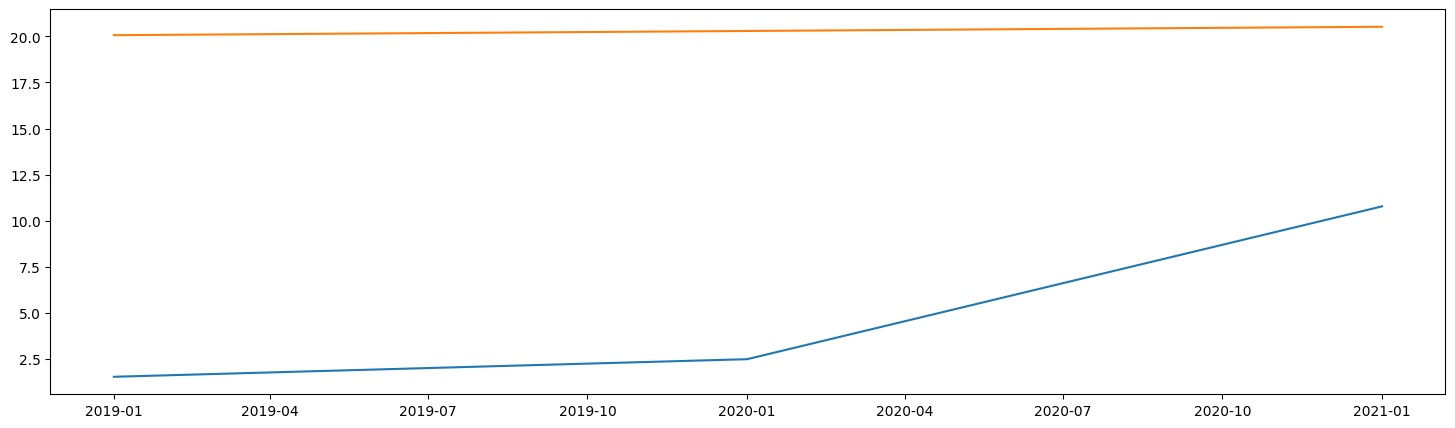

In [30]:
X_train = pd.DataFrame(
    range(ghana_gdp_interpolated["gdp_vol"].shape[0])
)[:train_df_full.shape[0]].fillna(0)

X_test = pd.DataFrame(
    range(ghana_gdp_interpolated["gdp_vol"].shape[0])
)[train_df_full.shape[0] :].fillna(0)

y_train = train_df_full["gdp_vol"].fillna(0)
y_test = test_df_full["gdp_vol"].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [43]:
print('LR-models MSE: ', end='')
print(round(mean_squared_error(y_test, lr_predict), 4))

LR-models MSE: 251.4089


Судя по графику и ошибке, arch-модель уловила дисперсию несколько хуже, чем простая линейная регрессия, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке.